In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from canopywatch.ml_logic.preprocessor import image_preprocessing, image_preprocessing_bulk, read_metadata_forest_file_to_df
from keras.callbacks import EarlyStopping
from canopywatch.params import DATA_PATH, LOCAL_REGISTRY_PATH
from canopywatch.ml_logic.model_linear import build_linear_model, compile_linear_model, fit_linear_model
from canopywatch.ml_logic.registry import save_model, save_results, local_load_metrics, local_load_params

# KERAS
from tensorflow.keras import models, layers, utils, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [6]:
data_path = '../data/Forest Segmented/meta_data.csv'
data = pd.read_csv(data_path)

In [7]:
images_path = '../data/Forest Segmented/images'
masks_path = '../data/Forest Segmented/masks'

data['image'] = images_path + '/' + data['image']
data['mask'] = masks_path + '/' + data['mask']
file_paths_image = list(data['image'])
file_paths_mask = list(data['mask'])

In [8]:
image_preprocessed = image_preprocessing_bulk(file_paths_image)
mask_preprocessed = image_preprocessing_bulk(file_paths_mask)

In [9]:
print(len(image_preprocessed))
print(image_preprocessed[0].shape)

5108
(256, 256, 3)


In [10]:
X = np.stack(image_preprocessed, axis=0)
print(X.shape)
print(type(X))

(5108, 256, 256, 3)
<class 'numpy.ndarray'>


In [11]:
mask_filepath = sorted([os.path.join(masks_path, f) for f in os.listdir(masks_path) if f.endswith('.jpg')])
def compute_percentage_forest(mask_filepath, data):
    percentages = []

    for i in range(0,5108):
        mask = image_preprocessing(mask_filepath[i])
        count_forest = np.count_nonzero(mask==1) #count number of values of pixels = 1 ie white pixels ie forest
        count_non_forest = np.count_nonzero(mask==0) #count number of values of pixels = 0 ie black pixels ie non_forest
        percentage_forest = count_forest/(count_forest+count_non_forest)
        percentages.append(percentage_forest)

    data['percentage_forest'] = percentages
    return data

data = compute_percentage_forest(mask_filepath, data)
data.head(10)

,image,mask,percentage_forest
0,../data/Forest Segmented/images/10452_sat_08.jpg,../data/Forest Segmented/masks/10452_mask_08.jpg,0.200314
1,../data/Forest Segmented/images/10452_sat_18.jpg,../data/Forest Segmented/masks/10452_mask_18.jpg,0.001864
2,../data/Forest Segmented/images/111335_sat_00.jpg,../data/Forest Segmented/masks/111335_mask_00.jpg,0.771197
3,../data/Forest Segmented/images/111335_sat_01.jpg,../data/Forest Segmented/masks/111335_mask_01.jpg,0.720740
4,../data/Forest Segmented/images/111335_sat_02.jpg,../data/Forest Segmented/masks/111335_mask_02.jpg,0.725204
5,../data/Forest Segmented/images/111335_sat_03.jpg,../data/Forest Segmented/masks/111335_mask_03.jpg,0.492098
6,../data/Forest Segmented/images/111335_sat_04.jpg,../data/Forest Segmented/masks/111335_mask_04.jpg,0.766804
7,../data/Forest Segmented/images/111335_sat_07.jpg,../data/Forest Segmented/masks/111335_mask_07.jpg,0.999985
8,../data/Forest Segmented/images/111335_sat_08.jpg,../data/Forest Segmented/masks/111335_mask_08.jpg,0.541126
9,../data/Forest Segmented/images/111335_sat_10.jpg,../data/Forest Segmented/masks/111335_mask_10.jpg,0.998926


In [12]:
y = np.array(data['percentage_forest'])
y.shape

(5108,)

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42)

In [14]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4341, 256, 256, 3), (767, 256, 256, 3), (4341,), (767,))

In [22]:
model = build_model_old(16, 3, False, dropout=0.0)
model.summary()

n_filters at Flatten=128
Model: "Linear"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_28 (Conv2D)          (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 128, 128, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None,

In [17]:
model_params = {'start_filters': 8, 'kernel_size': 3, 'dropout': 0.2, 'num_blocks': 4, 'optimizer': 'RMSprop', 'batch_size': 32}
model = build_linear_model(model_params)
model.summary()

Model: "Linear"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 8)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 128, 128, 8)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                        

In [19]:
model = compile_linear_model(model, model_params)

In [20]:
history = fit_linear_model(model, X_train, y_train, 10, model_params['batch_size'], 500, 0.15, True)

Epoch 1/500


2024-11-30 17:28:40.961712: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


116/116 [==============================] - 17s 141ms/step - loss: 155.0046 - mae: 1.7366 - val_loss: 0.3253 - val_mae: 0.4890
Epoch 2/500
116/116 [==============================] - 16s 140ms/step - loss: 0.2911 - mae: 0.4245 - val_loss: 0.1231 - val_mae: 0.3091
Epoch 3/500
116/116 [==============================] - 16s 141ms/step - loss: 0.1593 - mae: 0.3366 - val_loss: 0.1710 - val_mae: 0.3604
Epoch 4/500
116/116 [==============================] - 16s 139ms/step - loss: 0.1217 - mae: 0.2970 - val_loss: 0.2237 - val_mae: 0.4096
Epoch 5/500
116/116 [==============================] - 16s 140ms/step - loss: 0.1032 - mae: 0.2691 - val_loss: 0.1413 - val_mae: 0.3348
Epoch 6/500
116/116 [==============================] - 16s 142ms/step - loss: 0.0943 - mae: 0.2542 - val_loss: 0.1353 - val_mae: 0.3046
Epoch 7/500
116/116 [==============================] - 16s 142ms/step - loss: 0.0864 - mae: 0.2409 - val_loss: 0.1283 - val_mae: 0.3176
Epoch 8/500
116/116 [==============================] - 16s

In [63]:
type(history)

keras.callbacks.History

In [26]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))

    # --- LOSS ---

    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])

    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')

    ax[0].set_ylim((0, 1))

    ax[0].legend(['Train', 'Test'], loc='best')

    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    # --- ACCURACY

    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])

    ax[1].set_title('Model MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')

    ax[1].legend(['Train', 'Test'], loc='best')

    ax[1].set_ylim((0, 0.4))

    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    if title:
        fig.suptitle(title)

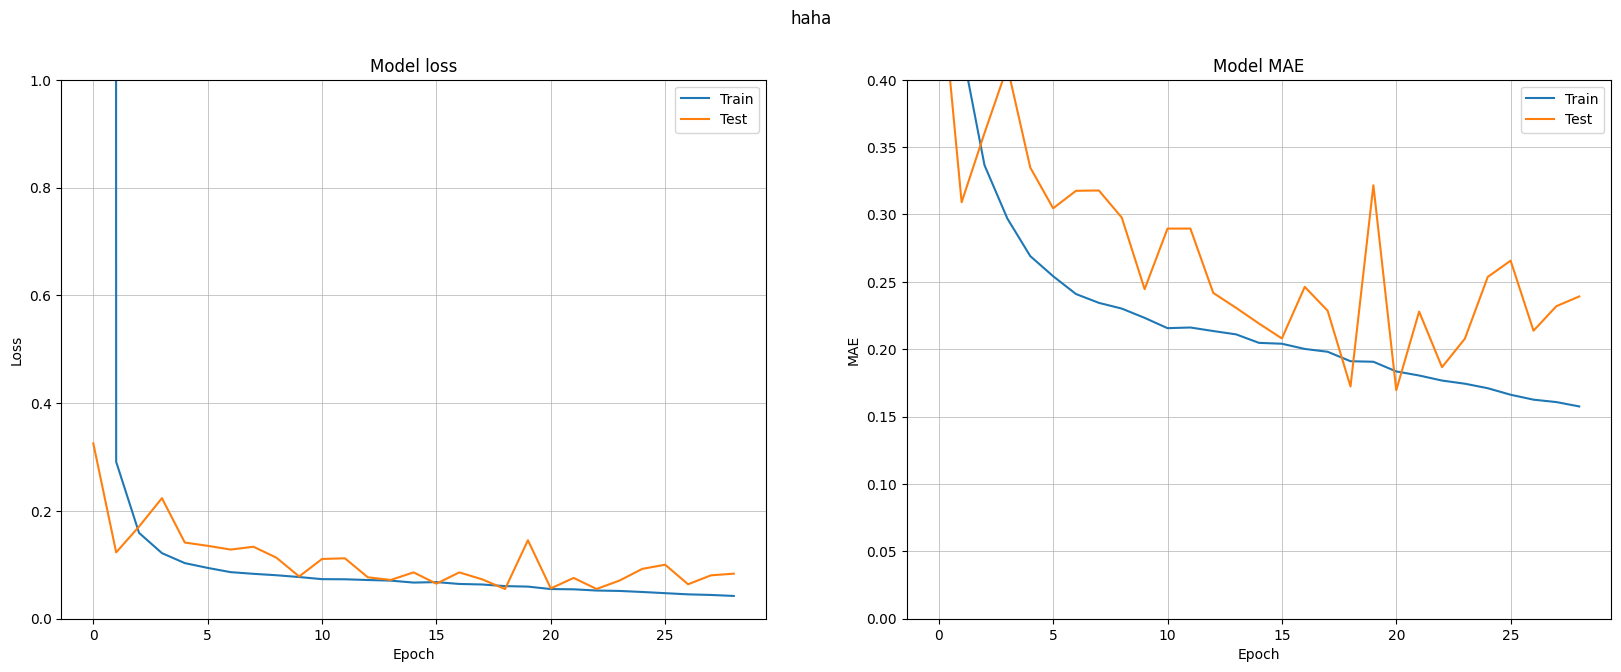

In [27]:
plot_loss_accuracy(history, "haha")

In [28]:
predictions = model.predict(X_test)

24/24 [==============================] - 1s 30ms/step


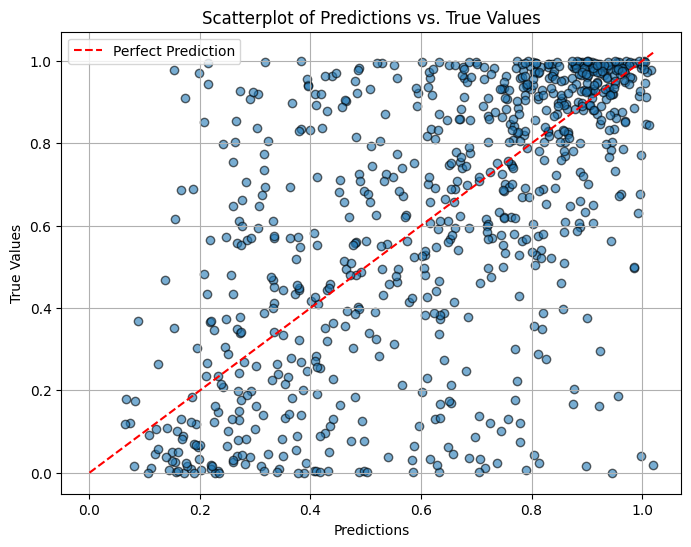

In [29]:
predictions_flattened = predictions.flatten()

# Create scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(predictions_flattened, y_test, alpha=0.6, edgecolor='k')
plt.title("Scatterplot of Predictions vs. True Values")
plt.xlabel("Predictions")
plt.ylabel("True Values")

# Add a diagonal line for reference
min_val = min(predictions_flattened.min(), y_test.min())
max_val = max(predictions_flattened.max(), y_test.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Perfect Prediction")
plt.legend()

# Show plot
plt.grid(True)
plt.show()

In [53]:
metrics = model.evaluate(x=X_test, y=y_test, return_dict=True)
metrics

24/24 [==============================] - 1s 59ms/step - loss: 0.0833 - mae: 0.2153


{'loss': 0.08334963768720627, 'mae': 0.2152826339006424}

In [56]:
save_results(model_params, metrics)

✅ Results saved locally


In [4]:
dir_path = LOCAL_REGISTRY_PATH + "/metrics"
picklen = len(".pickle")
data = []
for file in os.listdir(dir_path):
    if not file.startswith('.DS'):
        metrics = local_load_metrics(file[0:-picklen])
        params = local_load_params(file[0:-picklen])
        data.append((params, metrics))
        print(params)
        print(metrics)

{'start_filters': 8, 'kernel_size': 3, 'dropout': 0.3, 'num_blocks': 5, 'optimizer': 'RMSprop', 'batch_size': 32}
{'loss': 0.29900023341178894, 'mae': 0.4971611499786377}
{'start_filters': 8, 'kernel_size': 3, 'dropout': 0.3, 'num_blocks': 4, 'optimizer': 'RMSprop', 'batch_size': 32}
{'loss': 0.37175026535987854, 'mae': 0.55840665102005}
{'start_filters': 16, 'kernel_size': 3, 'dropout': 0.2, 'num_blocks': 5, 'optimizer': 'RMSprop', 'batch_size': 32}
{'loss': 0.13306386768817902, 'mae': 0.32236674427986145}
{'start_filters': 8, 'kernel_size': 3, 'dropout': 0.3, 'num_blocks': 4, 'optimizer': 'adam', 'batch_size': 32}
{'loss': 0.372712105512619, 'mae': 0.555698037147522}
{'start_filters': 16, 'kernel_size': 3, 'dropout': 0.2, 'num_blocks': 5, 'optimizer': 'adam', 'batch_size': 32}
{'loss': 0.36088600754737854, 'mae': 0.5483020544052124}
{'start_filters': 8, 'kernel_size': 5, 'dropout': 0.2, 'num_blocks': 3, 'optimizer': 'RMSprop', 'batch_size': 32}
{'loss': 0.09630254656076431, 'mae': 0.

<Figure size 1200x1000 with 0 Axes>

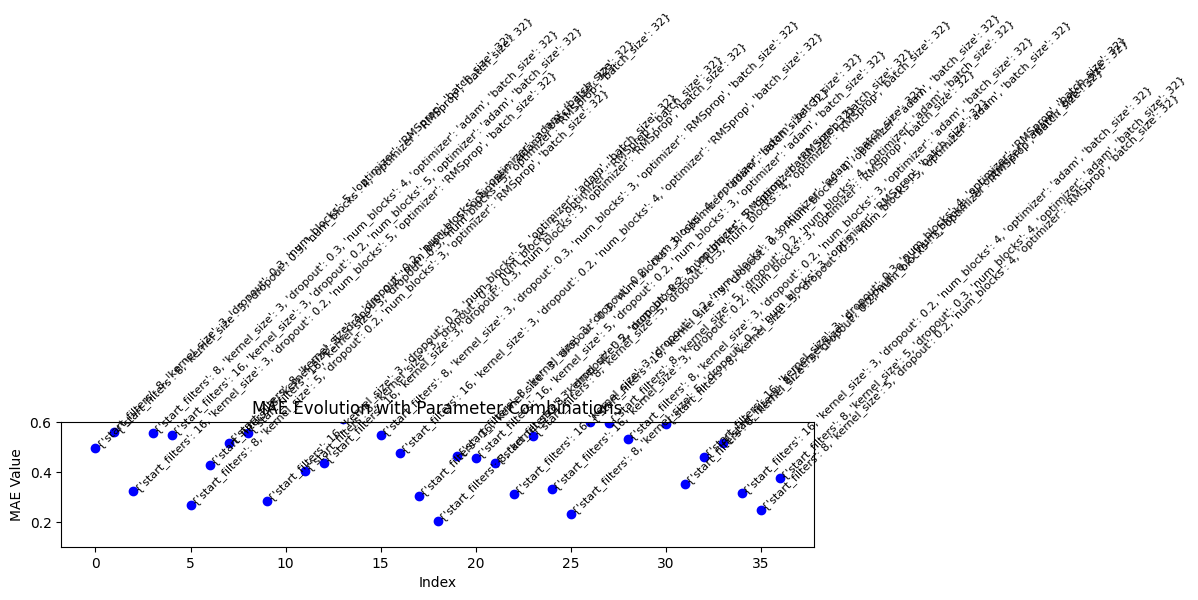

In [5]:
# data = [
#     ({"start_filters": 4, "kernel_size": 2, "twice": False, "dropout": 0.3, "num_blocks": 2},
#      {"loss": 1164.576, "mae": 28.9246}),
#     ({"start_filters": 4, "kernel_size": 2, "twice": True, "dropout": 0.2, "num_blocks": 5},
#      {"loss": 4156.717, "mae": 56.9804}),
#     ({"start_filters": 4, "kernel_size": 2, "twice": True, "dropout": 0.2, "num_blocks": 4},
#      {"loss": 1489.054, "mae": 33.8505}),
#     ({"start_filters": 4, "kernel_size": 2, "twice": True, "dropout": 0.1, "num_blocks": 2},
#      {"loss": 894.996, "mae": 24.4671}),
#     ({"start_filters": 4, "kernel_size": 3, "twice": True, "dropout": 0.1, "num_blocks": 4},
#      {"loss": 800.879, "mae": 23.2383}),
#     ({"start_filters": 4, "kernel_size": 2, "twice": False, "dropout": 0.1, "num_blocks": 3},
#      {"loss": 1181.805, "mae": 29.7601}),
#     ({"start_filters": 4, "kernel_size": 2, "twice": False, "dropout": 0.1, "num_blocks": 5},
#      {"loss": 1787.892, "mae": 37.3230}),
#     ({"start_filters": 4, "kernel_size": 2, "twice": True, "dropout": 0.3, "num_blocks": 3},
#      {"loss": 1319.011, "mae": 32.9920}),
#     ({"start_filters": 4, "kernel_size": 3, "twice": True, "dropout": 0.1, "num_blocks": 5},
#      {"loss": 1846.777, "mae": 38.0695}),
#     ({"start_filters": 4, "kernel_size": 2, "twice": True, "dropout": 0.1, "num_blocks": 4},
#      {"loss": 1604.709, "mae": 34.9021}),
#     ({"start_filters": 4, "kernel_size": 2, "twice": False, "dropout": 0.2, "num_blocks": 2},
#      {"loss": 1245.758, "mae": 31.5485}),
#     ({"start_filters": 4, "kernel_size": 2, "twice": False, "dropout": 0.1, "num_blocks": 4},
#      {"loss": 1386.871, "mae": 32.1069}),
# ]

# Extract MAE values and labels
mae_values = []
labels = []

for params, metrics in data:
    mae_values.append(metrics["mae"])
    labels.append(str(params))

# Create the scatterplot
plt.figure(figsize=(12, 10))
plt.figure(figsize=(12, 6))
plt.scatter(range(len(mae_values)), mae_values, color="blue")
plt.ylim(0.1, 0.6)

# Annotate the points
for i, label in enumerate(labels):
    plt.annotate(label, (i, mae_values[i]), fontsize=8, rotation=45)

# Add labels and title
plt.title("MAE Evolution with Parameter Combinations")
plt.xlabel("Index")
plt.ylabel("MAE Value")
plt.tight_layout()

# Show the plot
plt.show()